## Get scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/analysisFunctions.py

## Get data

In [3]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Extracting /content/speechData/train.tar.gz into /content/speechData/train
Extracting /content/speechData/test.tar.gz into /content/speechData/test


In [4]:
from getData import getDataframe
import pandas as pd

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test'], include_unknown=True) 
finalTestDF = getDataframe(dataDict['finalTest'], include_unknown=True) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(finalTestDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 3081


In [5]:
trainDF.head()

,files,labels,category
0,speechData/train/five/7e556a2c_nohash_0.wav,20,five
1,speechData/train/off/96a48d28_nohash_3.wav,2,off
2,speechData/train/happy/b71ebf79_nohash_0.wav,18,happy
3,speechData/train/two/89d6d11e_nohash_0.wav,29,two
4,speechData/train/eight/6a700f9d_nohash_1.wav,5,eight


## Install tf 2.0 and python speech features

In [6]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 63kB/s 
     |████████████████████████████████| 501kB 59.2MB/s 
     |████████████████████████████████| 3.1MB 54.9MB/s 


In [7]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


In [8]:
!pip install -q python_speech_features

## Train model

In [46]:
def cnnModel(input_shape=(99, 40)):
    """
    Model consisting of 4 convolution blocks
    """

    model = tf.keras.models.Sequential()

    # Normalization layer
    model.add(tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(99, 40, 1)))
    model.add(tf.keras.layers.BatchNormalization())

    filters = [16, 32, 64, 128]

    for num_filters in filters:
        # Conv a
        model.add(tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding='same'
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        # Conv b
        model.add(tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding='same'
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        # Pooling
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.2))

    # Classification layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(30, activation='softmax'))

    return model

model = cnnModel()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 99, 40, 1)         0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 99, 40, 1)         4         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 99, 40, 16)        160       
_________________________________________________________________
batch_normalization_31 (Batc (None, 99, 40, 16)        64        
_________________________________________________________________
activation_27 (Activation)   (None, 99, 40, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 99, 40, 16)        2320      
_________________________________________________________________
batch_normalization_32 (Batc (None, 99, 40, 16)       

In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset by using a numer <60k
NUM_EXAMPLES = 100000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True,
    scale=False
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False,
    scale=False
)

In [48]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])


EPOCHS = 40

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("cnn_dropout_256.h5", monitor='val_loss', save_best_only=True)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])

Epoch 1/40
1596/1596 [==============================] - 56s 35ms/step - loss: 2.0960 - sparse_categorical_accuracy: 0.3951 - val_loss: 0.7007 - val_sparse_categorical_accuracy: 0.7818
Epoch 2/40
1596/1596 [==============================] - 46s 29ms/step - loss: 0.6493 - sparse_categorical_accuracy: 0.8060 - val_loss: 0.3362 - val_sparse_categorical_accuracy: 0.9037
Epoch 3/40
1596/1596 [==============================] - 44s 28ms/step - loss: 0.4460 - sparse_categorical_accuracy: 0.8702 - val_loss: 0.3009 - val_sparse_categorical_accuracy: 0.9133
Epoch 4/40
1596/1596 [==============================] - 44s 28ms/step - loss: 0.3580 - sparse_categorical_accuracy: 0.8979 - val_loss: 0.3022 - val_sparse_categorical_accuracy: 0.9141
Epoch 5/40
1596/1596 [==============================] - 44s 28ms/step - loss: 0.3203 - sparse_categorical_accuracy: 0.9107 - val_loss: 0.2036 - val_sparse_categorical_accuracy: 0.9435
Epoch 6/40
1596/1596 [==============================] - 44s 28ms/step - loss: 0.

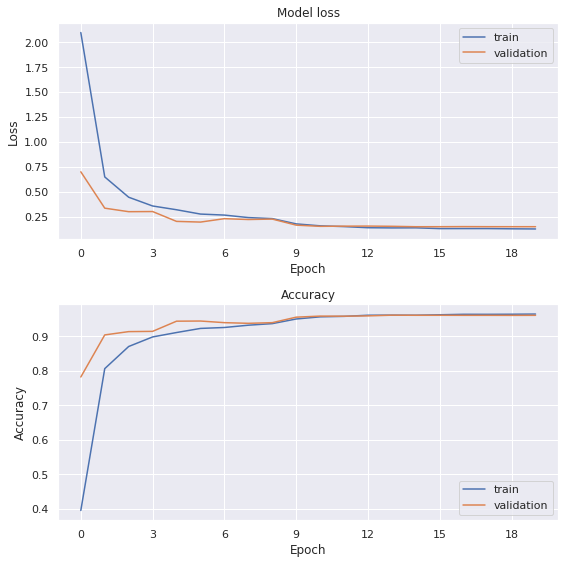

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

## Save model

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [52]:
GDRIVE_PATH = "/content/gdrive/My Drive/speechRecognition/cnnModel/"

model.save(GDRIVE_PATH + "VGG_4B_256_30_dropout.h5")
print("Saved model to drive")

Saved model to drive


In [53]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_history_VGG_4B_256_30_dropout.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


## Extract features

In [0]:
from trainingUtils import getDataset

marvin_data, _ = getDataset(
    df=trainDF.loc[trainDF['category']=='marvin', :],
    batch_size=32,
    cache_file='oc_train_cache',
    shuffle=False
)

In [55]:
valDF['oc_class'] = valDF.apply(lambda row: 1 if row['category']=='marvin' else -1, axis=1)
val_true = valDF['oc_class'].tolist()
valDF.head()

,files,labels,category,oc_class
0,speechData/train/bed/026290a7_nohash_0.wav,16,bed,-1
1,speechData/train/bed/060cd039_nohash_0.wav,16,bed,-1
2,speechData/train/bed/060cd039_nohash_1.wav,16,bed,-1
3,speechData/train/bed/099d52ad_nohash_0.wav,16,bed,-1
4,speechData/train/bed/0e17f595_nohash_0.wav,16,bed,-1


In [0]:
def getFeatures(data):
    layer_name = 'dense_10'
    layer_out = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return layer_out.predict(data, use_multiprocessing=True)

In [0]:
from trainingUtils import _loadWavs, _logMelFilterbank

def _parse_fn(filename):
    wave = _loadWavs(filename)
    fbank = _logMelFilterbank(wave)
    return fbank

In [0]:
import numpy as np
valData = np.zeros((valDF.shape[0], 99, 40))

for i,f in enumerate(valDF['files']):
    valData[i] = _parse_fn(f)

In [0]:
X_train = getFeatures(marvin_data)
X_val = getFeatures(valData)

## Isolation Forest

In [121]:
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest

contamination_list = np.arange(0.005, 0.2, 0.005)
max_samples_list = np.arange(1, 200, 5)

best_score = 0
scores = np.zeros((contamination_list.shape[0], max_samples_list.shape[0]))
best_parameters = {'contamination':0, 'max_samples':0}

iterations = contamination_list.shape[0] * max_samples_list.shape[0]
iteration = 1

for i, contamination in enumerate(contamination_list):
    for j, max_samples in enumerate(max_samples_list):
        
        if(iteration%100==0):
            print("Iteration {}/{}".format(iteration, iterations))
        
        isf = IsolationForest(
            random_state=42,
            contamination=contamination,
            max_samples=max_samples,
            max_features=0.1,
            bootstrap='True',
            behaviour='new',
            n_jobs=-1
        )
        isf.fit(X_train)
        
        val_pred = isf.predict(X_val)
                
        score = f1_score(val_pred, val_true)
        
        if score>best_score:
            print("New best score: {:4f}".format(score))     
            best_score = score
            best_parameters['contamination'] = contamination
            best_parameters['max_samples'] = max_samples
            
        scores[i][j] = score
        iteration += 1

New best score: 0.045990
New best score: 0.076866
New best score: 0.166141
New best score: 0.186541
New best score: 0.194479
New best score: 0.263158
New best score: 0.339130
New best score: 0.363636
New best score: 0.409031
New best score: 0.514190
New best score: 0.531952
New best score: 0.647059
New best score: 0.724299
New best score: 0.815789
New best score: 0.927711
New best score: 0.936170
New best score: 0.959502
New best score: 0.965517
New best score: 0.968553
Iteration 100/1560
New best score: 0.980892
Iteration 200/1560
Iteration 300/1560
Iteration 400/1560
Iteration 500/1560
Iteration 600/1560
Iteration 700/1560
Iteration 800/1560
Iteration 900/1560
Iteration 1000/1560
Iteration 1100/1560
Iteration 1200/1560
Iteration 1300/1560
Iteration 1400/1560
Iteration 1500/1560


In [122]:
print(best_parameters)
print("Best F1 score: {:.4f}".format(best_score))

{'contamination': 0.015, 'max_samples': 96}
Best F1 score: 0.9809


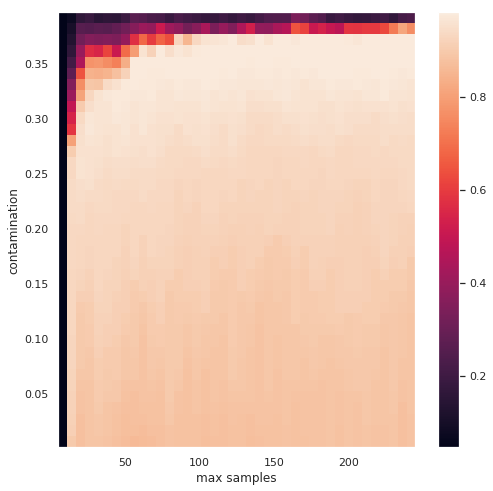

In [215]:
fig, ax = plt.subplots(figsize=(8,8))

im = ax.imshow(scores, aspect="auto", extent=[max_samples_list[0], max_samples_list[-1], contamination_list[0], contamination_list[-1]])
fig.colorbar(im, orientation='vertical')

ax.set_xlabel('max samples')
ax.set_ylabel('contamination')

#ax.scatter(best_parameters['max_samples'], best_parameters['contamination'], c='red', s=100, marker='*')

ax.grid(False)

fig.show()

Accuracy: 0.9991
Precision: 1.0000
Recal: 0.9625
F1-score: 0.9809


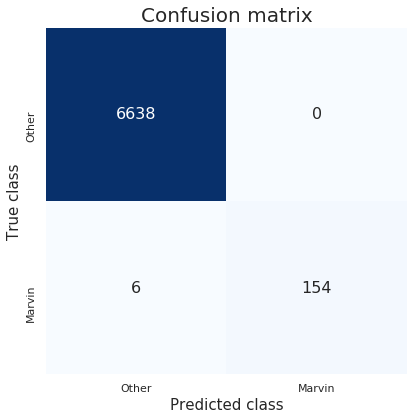

In [177]:
from analysisFunctions import showResultsOC

best_isf = IsolationForest( 
    random_state=42,
    contamination=0.02,
    max_samples=100,
    max_features=0.1,
    bootstrap='True',
    behaviour='new',
    n_jobs=-1)

best_isf.fit(X_train)

val_pred = best_isf.predict(X_val)

showResultsOC(val_pred, val_true)

## More tests

In [0]:
import pandas as pd 

dfTest = pd.concat([testDF,finalTestDF],ignore_index=True)

In [0]:
testData = np.zeros((dfTest.shape[0], 99, 40))

for i,f in enumerate(dfTest['files']):
    testData[i] = _parse_fn(f)
    
X_test = getFeatures(testData)

In [67]:
dfTest['oc_class'] = dfTest.apply(lambda row: 1 if row['category']=='marvin' else -1, axis=1)
test_true = dfTest['oc_class'].tolist()
dfTest.loc[dfTest['category']=='_background_noise_', :].head()

,files,labels,category,oc_class
8116,speechData/test/_silence_/555.wav,30,_background_noise_,-1
8117,speechData/test/_silence_/2227.wav,30,_background_noise_,-1
8118,speechData/test/_silence_/2275.wav,30,_background_noise_,-1
8119,speechData/test/_silence_/2588.wav,30,_background_noise_,-1
8120,speechData/test/_silence_/1257.wav,30,_background_noise_,-1


Accuracy: 0.9969
Precision: 0.9226
Recal: 0.8827
F1-score: 0.9022


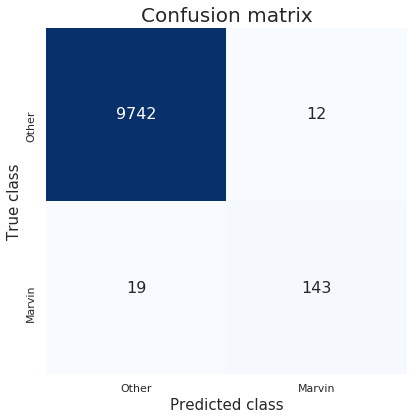

In [175]:
test_pred = best_isf.predict(X_test)
showResults(test_pred, test_true)

In [129]:
contamination_list = np.arange(0.001, 0.4, 0.005)
max_samples_list = np.arange(5, 250, 5)

best_score_tmp = 0
scores_tmp = np.zeros((contamination_list.shape[0], max_samples_list.shape[0]))
best_parameters_tmp = {'contamination':0, 'max_samples':0}

iterations = contamination_list.shape[0] * max_samples_list.shape[0]
iteration = 1

print("Total iterations: {}".format(iterations))
 
for i, contamination in enumerate(contamination_list):
    for j, max_samples in enumerate(max_samples_list):
        
        if(iteration%100==0):
            print("Iteration {}/{}".format(iteration, iterations))
        
        isf = IsolationForest(
            random_state=42,
            contamination=contamination,
            max_samples=max_samples,
            max_features=0.1,
            bootstrap='True',
            behaviour='new',
            n_jobs=-1
        )
        isf.fit(X_train)
        
        test_pred = isf.predict(X_test)
                
        score = f1_score(test_pred, test_true)
        
        if score>best_score_tmp:
            print("New best score: {:4f}".format(score))     
            best_score_tmp = score
            best_parameters_tmp['contamination'] = contamination
            best_parameters_tmp['max_samples'] = max_samples
            
        scores_tmp[i][j] = score
        iteration += 1

Total iterations: 3920
New best score: 0.033132
New best score: 0.058888
New best score: 0.073667
New best score: 0.080379
New best score: 0.090424
New best score: 0.091607
New best score: 0.098171
New best score: 0.098622
New best score: 0.104886
New best score: 0.150426
New best score: 0.172171
New best score: 0.178953
New best score: 0.215447
New best score: 0.223322
New best score: 0.234421
New best score: 0.296365
New best score: 0.301815
New best score: 0.306796
New best score: 0.312871
Iteration 100/3920
New best score: 0.346667
New best score: 0.347439
New best score: 0.390977
New best score: 0.392947
New best score: 0.454810
New best score: 0.519135
New best score: 0.543554
New best score: 0.673866
New best score: 0.690265
New best score: 0.742857
New best score: 0.849315
New best score: 0.852459
New best score: 0.865922
New best score: 0.899135
New best score: 0.901163
New best score: 0.919881
New best score: 0.933333
New best score: 0.939024
New best score: 0.942249
Iteratio

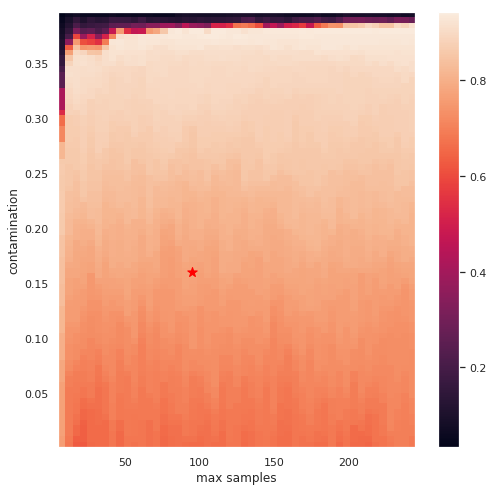

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

fig, ax = plt.subplots(figsize=(8,8))

im = ax.imshow(scores_tmp, aspect="auto", extent=[max_samples_list[0], max_samples_list[-1], contamination_list[0], contamination_list[-1]])
fig.colorbar(im, orientation='vertical')

ax.set_xlabel('max samples')
ax.set_ylabel('contamination')

#ax.scatter(best_parameters_tmp['max_samples'], best_parameters_tmp['contamination'], c='red', s=100, marker='*')

ax.grid(False)

fig.show()

In [139]:
!ls gdrive/My\ Drive/speechRecognition/OC

scores_X_test.npy


In [0]:
np.save("gdrive/My Drive/speechRecognition/OC/scores_X_test.npy", scores_tmp)

In [184]:
_ = """isf_noise = IsolationForest(
    random_state=42,
    contamination=best_parameters_tmp['contamination'],
    max_samples=best_parameters_tmp["max_samples"],
    bootstrap='True', behaviour='new')"""
isf_noise = IsolationForest(
    random_state=42,
    contamination=0.015,
    max_samples=95,
    max_features=0.1,
    bootstrap='True', behaviour='new')
isf_noise.fit(X_train)

IsolationForest(behaviour='new', bootstrap='True', contamination=0.015,
                max_features=0.1, max_samples=95, n_estimators=100, n_jobs=None,
                random_state=42, verbose=0, warm_start=False)

Accuracy: 0.9980
Precision: 0.9226
Recal: 0.9568
F1-score: 0.9394


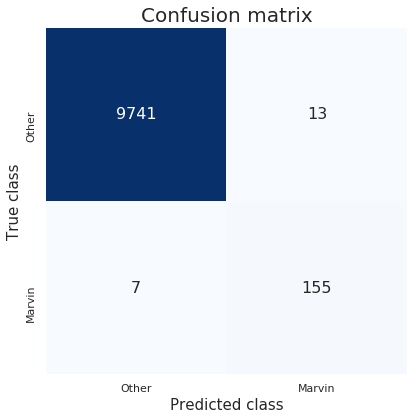

In [185]:
test_pred = isf_noise.predict(X_test)
showResults(test_pred, test_true)

Accuracy: 0.9991
Precision: 1.0000
Recal: 0.9625
F1-score: 0.9809


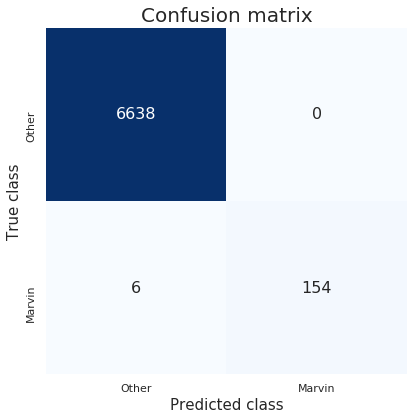

In [186]:
val_pred = isf_noise.predict(X_val)
showResults(val_pred, val_true)

## OC-SVM

In [96]:
from sklearn.metrics import f1_score
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

gamma_bgn, gamma_end, num_gamma  = 1e-05, 0.04, 40 
nu_bgn, nu_end, num_nu  = 1e-04, 5e-01, 40

gamma_list = np.arange(gamma_bgn, gamma_end, (gamma_end - gamma_bgn) / num_gamma)[::-1]
nu_list = np.arange(nu_bgn, nu_end, (nu_end - nu_bgn) / num_nu)

best_score_svm = 0
scores_svm = np.zeros((gamma_list.shape[0], nu_list.shape[0]))
best_parameters_svm = {'gamma':0, 'nu':0}

iterations = gamma_list.shape[0] * nu_list.shape[0]
iteration = 1

for i, gamma in enumerate(gamma_list):
    for j, nu in enumerate(nu_list):
        
        if(iteration%100==0):
            print("Iteration {}/{}".format(iteration, iterations))
            
        oc_svm = svm.OneClassSVM(gamma=gamma, nu=nu)
        ocmodel = oc_svm.fit(X_train)
   
        val_pred = oc_svm.predict(X_val)
                
        score = f1_score(val_pred, val_true)
        
        if score>best_score_svm:
            print("New best score: {:4f}".format(score))     
            best_score_svm = score
            best_parameters_svm['gamma'] = gamma
            best_parameters_svm['nu'] = nu
            
        scores_svm[i][j] = score
        iteration += 1

New best score: 0.535117
New best score: 0.597015
New best score: 0.643678
New best score: 0.679389
Iteration 100/1600
New best score: 0.730627
Iteration 200/1600
New best score: 0.747170
New best score: 0.756364
Iteration 300/1600
Iteration 400/1600
Iteration 500/1600
Iteration 600/1600
New best score: 0.758170
New best score: 0.759582
New best score: 0.765273
New best score: 0.782313
Iteration 700/1600
New best score: 0.783784
New best score: 0.795987
New best score: 0.798680
New best score: 0.801471
Iteration 800/1600
New best score: 0.803922
New best score: 0.804270
New best score: 0.805195
New best score: 0.806557
New best score: 0.809365
New best score: 0.816609
New best score: 0.825175
New best score: 0.832215
Iteration 900/1600
New best score: 0.833333
New best score: 0.835714
New best score: 0.843537
New best score: 0.849123
New best score: 0.859107
New best score: 0.859155
Iteration 1000/1600
New best score: 0.866197
New best score: 0.874126
New best score: 0.878049
Iteration

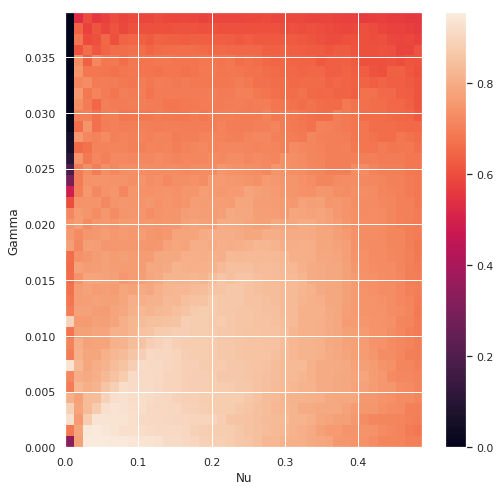

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

fig, ax = plt.subplots(figsize=(8,8))

im = ax.imshow(scores_svm, aspect="auto", extent=[nu_list[0], nu_list[-1], gamma_list[-1], gamma_list[0]])
fig.colorbar(im, orientation='vertical')

ax.set_xlabel('Nu')
ax.set_ylabel('Gamma')

#ax.scatter(best_parameters_svm['nu'], best_parameters_svm['gamma'], c='red', s=100, marker='*')

fig.show()

Accuracy: 0.9979
Precision: 0.9803
Recal: 0.9313
F1-score: 0.9551


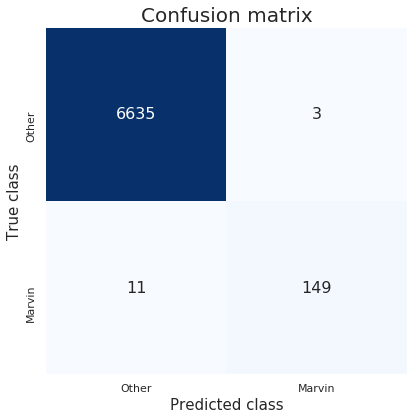

In [193]:
best_svm = svm.OneClassSVM(gamma = 5e-06, nu=0.025)
best_svm.fit(X_train)

val_pred = best_svm.predict(X_val)
showResults(val_pred, val_true)

## PCA

In [194]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

pca.fit(X_train)

print(sum(pca.explained_variance_ratio_)) 

0.9859188554110005


In [0]:
X_train_transformed = pca.transform(X_train)
X_val_transformed = pca.transform(X_val)
X_test_transformed = pca.transform(X_test)

In [204]:
gamma_bgn, gamma_end, num_gamma  = 1e-06, 0.01, 40 
nu_bgn, nu_end, num_nu  = 1e-04, 5e-01, 30

gamma_list = np.arange(gamma_bgn, gamma_end, (gamma_end - gamma_bgn) / num_gamma)#[::-1]
nu_list = np.arange(nu_bgn, nu_end, (nu_end - nu_bgn) / num_nu)

best_score_svm = 0
scores_svm = np.zeros((gamma_list.shape[0], nu_list.shape[0]))
best_parameters_svm = {'gamma':0, 'nu':0}

iterations = gamma_list.shape[0] * nu_list.shape[0]
iteration = 1

for i, gamma in enumerate(gamma_list):
    for j, nu in enumerate(nu_list):
        
        if(iteration%100==0):
            print("Iteration {}/{}".format(iteration, iterations))
            
        oc_svm = svm.OneClassSVM(gamma=gamma, nu=nu)
        ocmodel = oc_svm.fit(X_train_transformed)
   
        val_pred = oc_svm.predict(X_val_transformed)
                
        score = f1_score(val_pred, val_true)
        
        if score>best_score_svm:
            print("New best score: {:4f}".format(score))     
            best_score_svm = score
            best_parameters_svm['gamma'] = gamma
            best_parameters_svm['nu'] = nu
            
        scores_svm[i][j] = score
        iteration += 1

New best score: 0.290875
New best score: 0.927900
New best score: 0.951140
New best score: 0.954545
New best score: 0.964401
Iteration 100/1240
Iteration 200/1240
Iteration 300/1240
Iteration 400/1240
Iteration 500/1240
Iteration 600/1240
Iteration 700/1240
Iteration 800/1240
Iteration 900/1240
Iteration 1000/1240
Iteration 1100/1240
Iteration 1200/1240


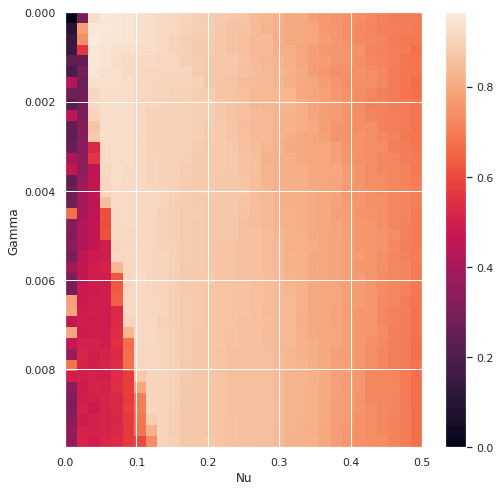

In [214]:
fig, ax = plt.subplots(figsize=(8,8))

im = ax.imshow(scores_svm, aspect="auto", extent=[nu_list[0], nu_list[-1], gamma_list[-1], gamma_list[0]])
fig.colorbar(im, orientation='vertical')

ax.set_xlabel('Nu')
ax.set_ylabel('Gamma')

#ax.scatter(best_parameters_svm['nu'], best_parameters_svm['gamma'], c='red', s=100, marker='*')

fig.show()

Accuracy: 0.9981
Precision: 0.9868
Recal: 0.9313
F1-score: 0.9582


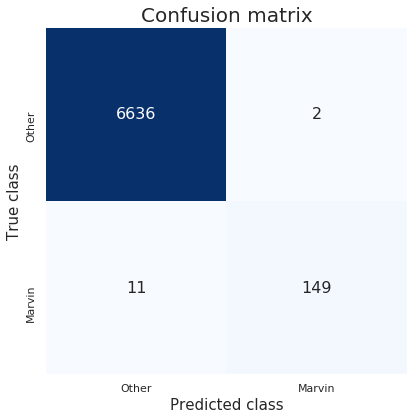

In [213]:
oc_svm = svm.OneClassSVM(gamma=0.0005, nu=0.03)
ocmodel = oc_svm.fit(X_train_transformed)

val_pred = oc_svm.predict(X_val_transformed)
showResultsOC(val_pred, val_true)